In [1]:
# Add the location of `nistreamer` package to `sys.path`
import sys
import os
sys.path.append(os.path.join(r'/absolute/path/of/ni-streamer/py_api'))

In [2]:
from nistreamer import NIStreamer
from nistreamer.utils import iplot, RendOption
import numpy as np

### Instantiate streamer, cards, and channels

In [3]:
ni_streamer = NIStreamer()

#### Add cards

In [4]:
fast_ao_card = ni_streamer.add_ao_card(max_name='PXI1Slot3', samp_rate=1e6, nickname='fast_ao_card',)
slow_ao_card = ni_streamer.add_ao_card(max_name='PXI1Slot4', samp_rate=250e3, nickname='slow_ao_card')
do_card = ni_streamer.add_do_card(max_name='PXI1Slot6', samp_rate=10e6, nickname='do_card')

Configure inter-card sync:

In [5]:
TRIG_LINE = 'PXI_Trig0'
REF_CLK_LINE = 'PXI_Trig7'

fast_ao_card.start_trig_out = TRIG_LINE
slow_ao_card.start_trig_in = TRIG_LINE
do_card.start_trig_in = TRIG_LINE
do_card.samp_clk_src = REF_CLK_LINE

ni_streamer.starts_last = fast_ao_card.max_name
ni_streamer.ref_clk_provider = (fast_ao_card.max_name, REF_CLK_LINE)

#### Add channels

In [6]:
drive = fast_ao_card.add_chan(chan_idx=0, nickname='drive')

In [7]:
src_shutter = do_card.add_chan(port_idx=0, line_idx=0, nickname='src_shutter')
src_pwr = slow_ao_card.add_chan(chan_idx=0, nickname='src_pwr')

In [8]:
gate = do_card.add_chan(port_idx=0, line_idx=1, nickname='gate')

### Pulse sequence script

In [10]:
# Two parameters to sweep:
tau_arr = np.linspace(0.5, 10, 100) * 1e-3
pwr_arr = [0.1, 0.2, 0.5, 0.6, 1.0]

# Constant parameters
drive_amp = 0.5
drive_freq = 100e3

gate_dur = 1e-3
src_shutter_lag = 0.5e-3

safety_buf = 50e-6
inter_rep_gap = 1e-3

In [11]:
ni_streamer.clear_edit_cache()

In [12]:
# Convenience variable to keep track of current time:
t = 0  

for pwr in pwr_arr:
    for tau in tau_arr:
        
        # 1st gate pulse
        t += gate.high(t=t, dur=gate_dur)
        
        t += safety_buf
        
        # Sine drive pulse
        t += drive.sine(t=t, dur=tau, amp=drive_amp, freq=drive_freq)
        
        t += safety_buf
        
        # Simultaneous 2nd gate and source pulses
        gate.high(t=t, dur=gate_dur)
        
        src_pwr.const(t=t, dur=gate_dur, val=pwr)
        src_shutter.high(t=t-src_shutter_lag, dur=gate_dur)
        t += gate_dur
        
        # Buffer before next repetition
        t += inter_rep_gap

### Compile, preview, and stream

In [14]:
ni_streamer.compile()

4.1739999999999995

In [15]:
iplot(chan_list=[gate, drive, src_pwr, src_shutter],
    start_time=0.10,
    end_time=0.15,
    nsamps=int(1.2345678e5)
)

A | B | C | D
- | - | - | -
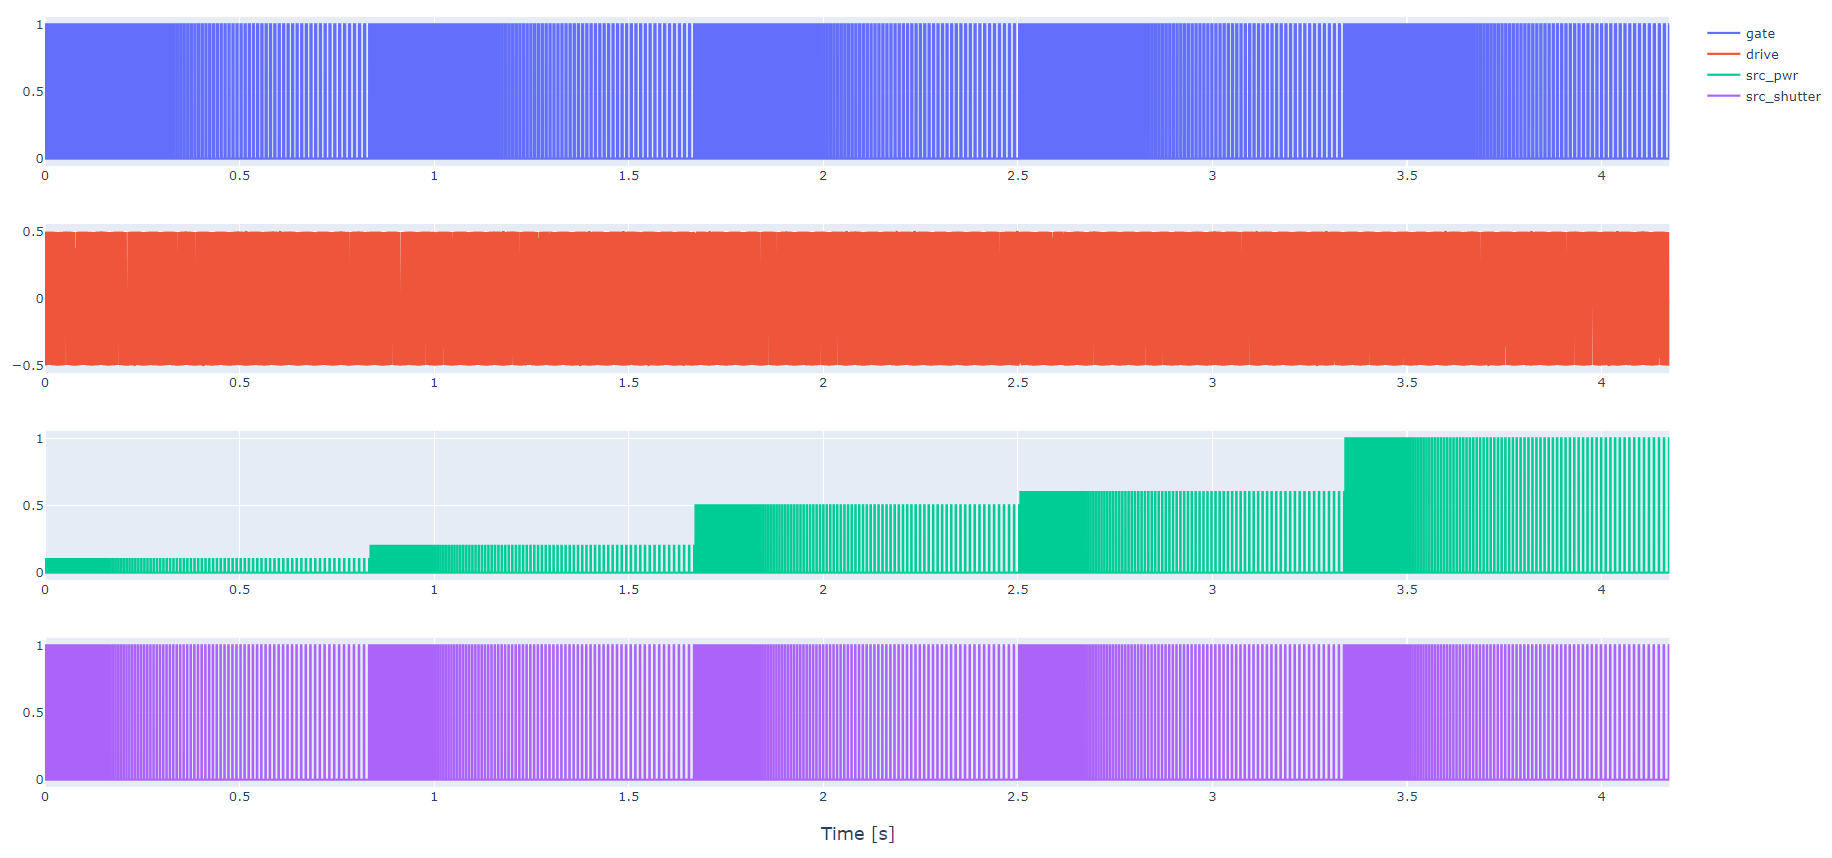 | 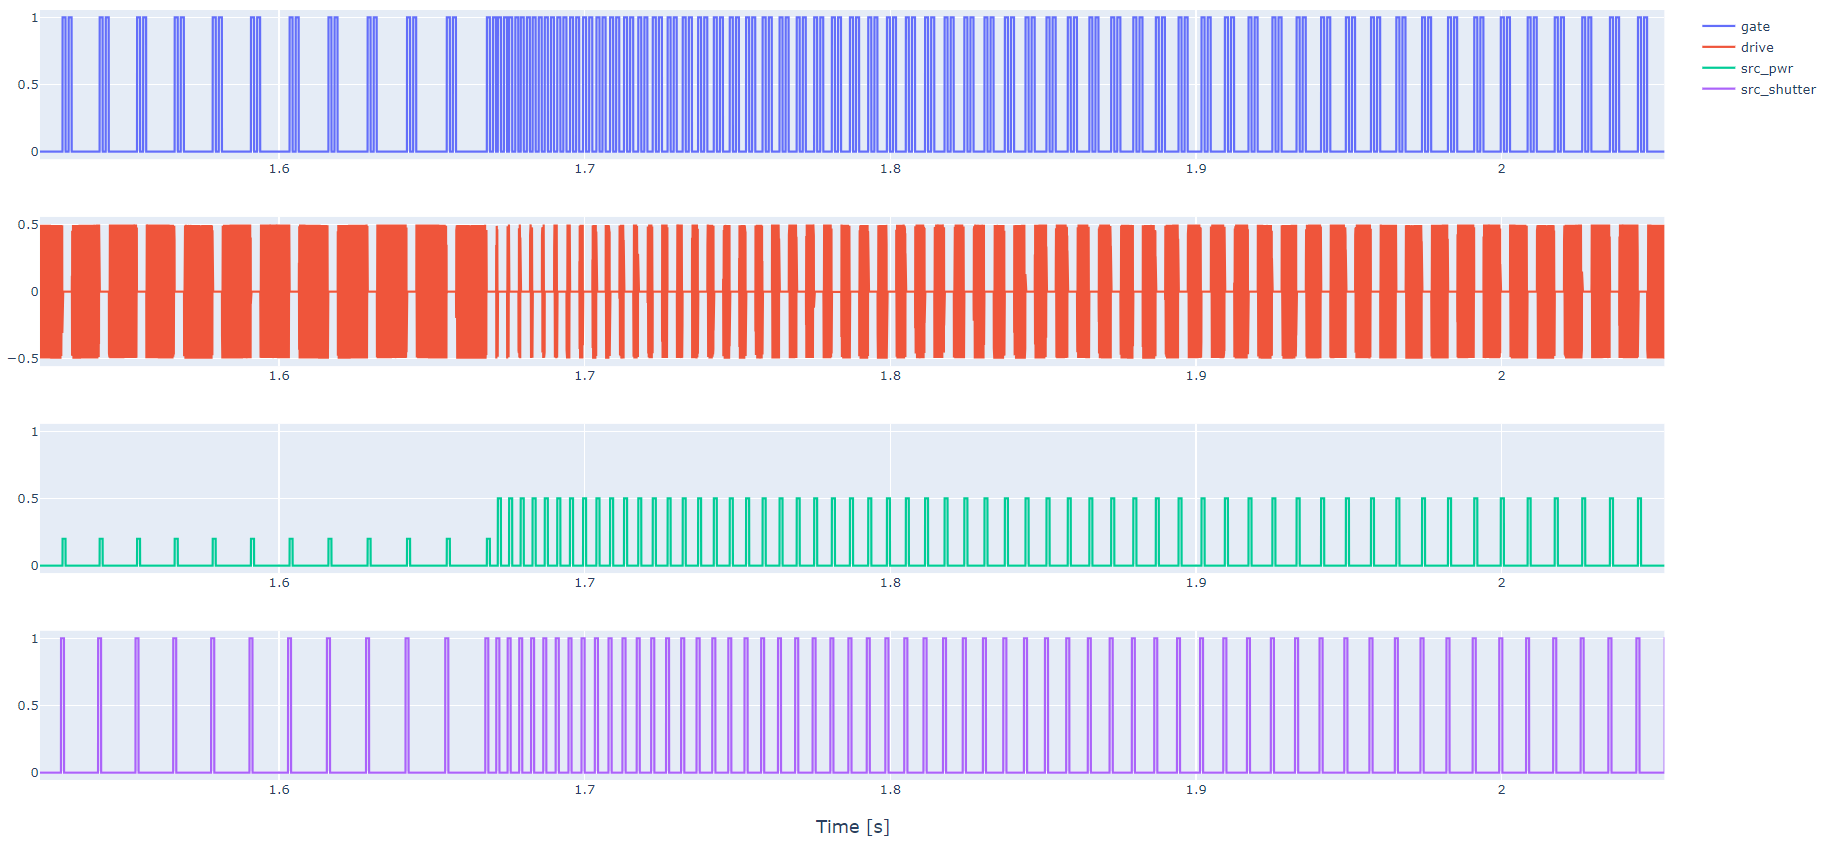 | 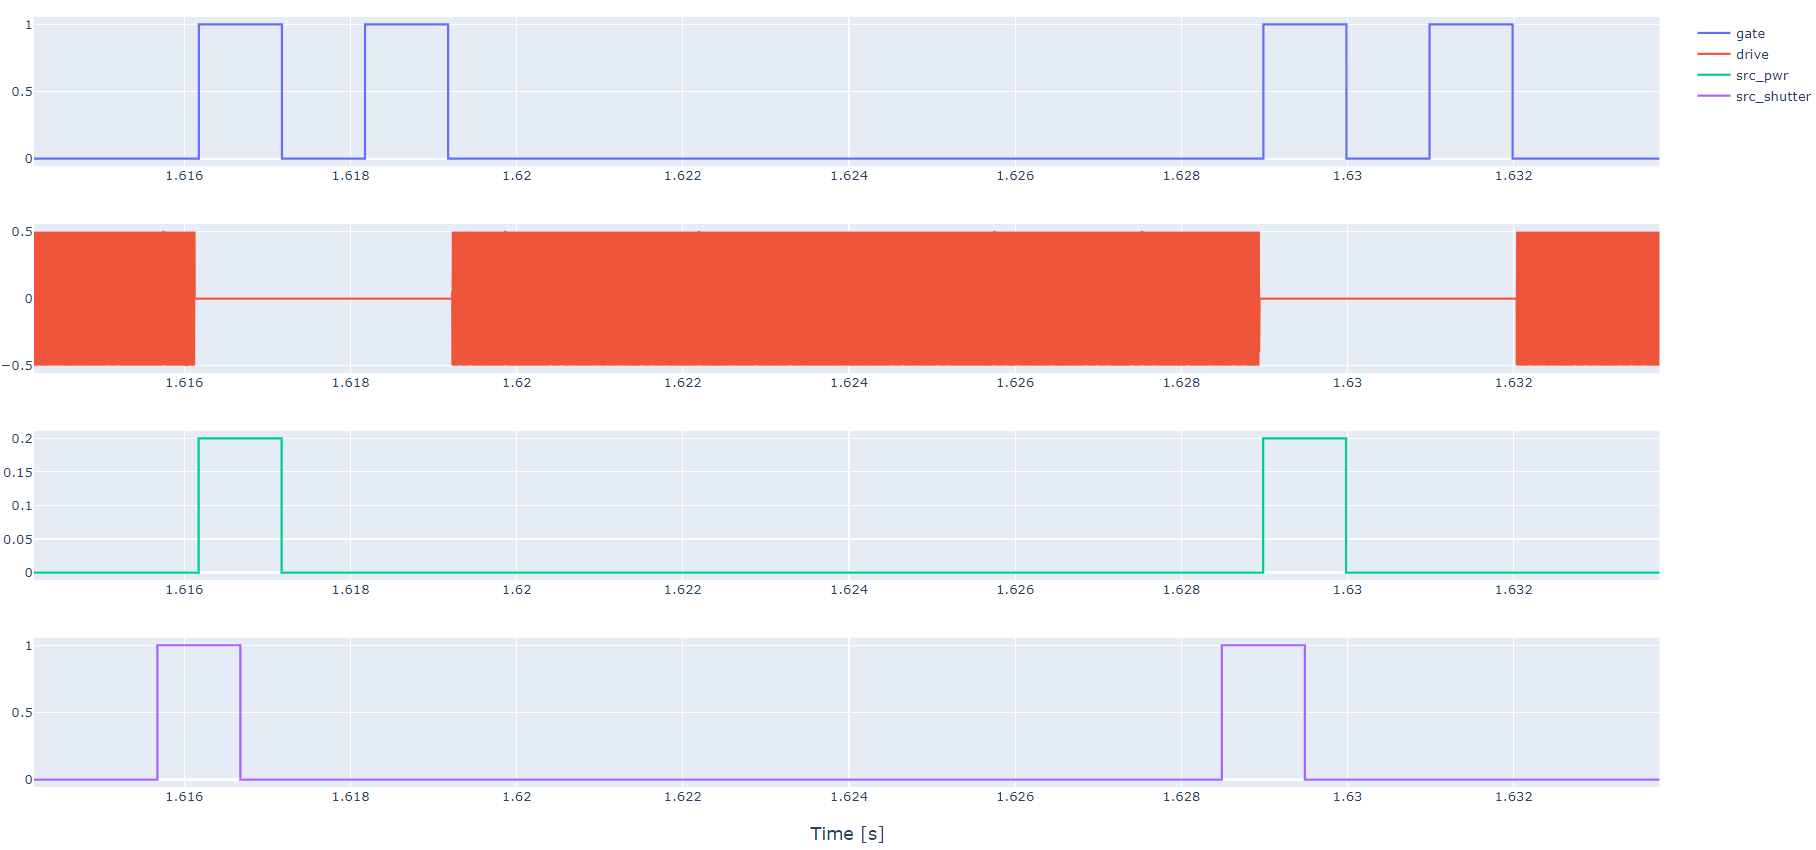 | 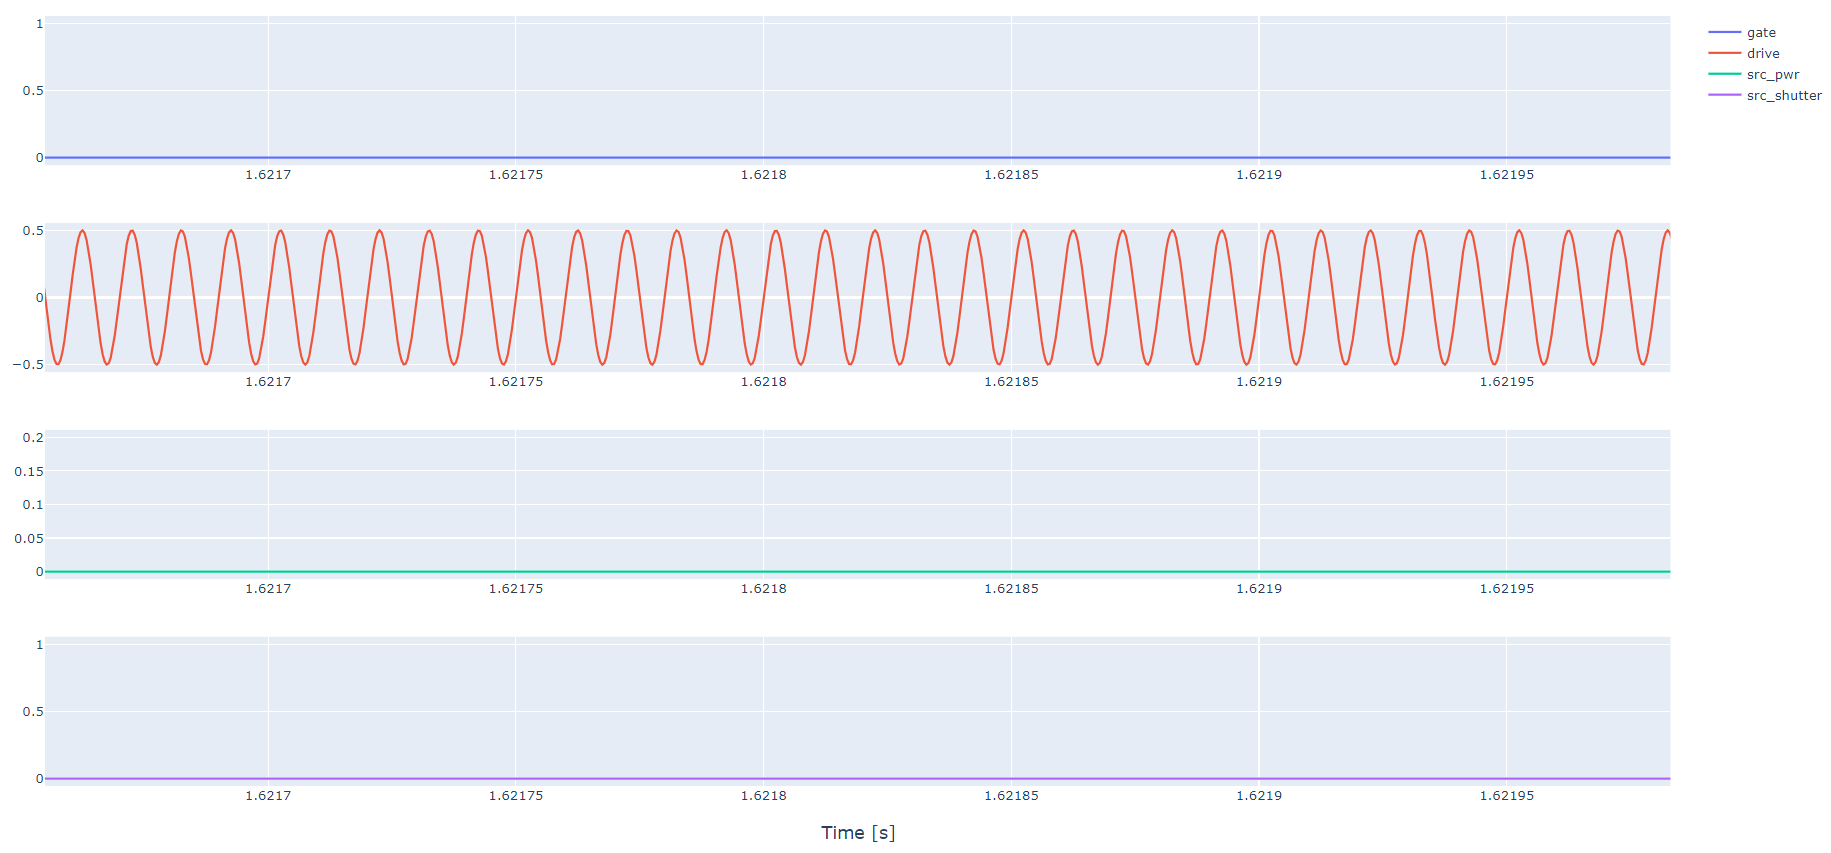

In [18]:
ni_streamer.run(nreps=2)

A | B | C | D
- | - | - | -
 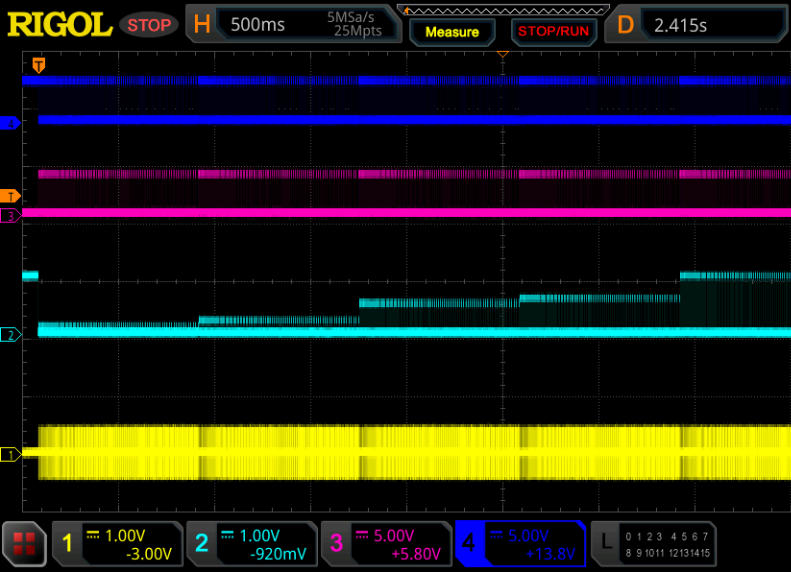 | 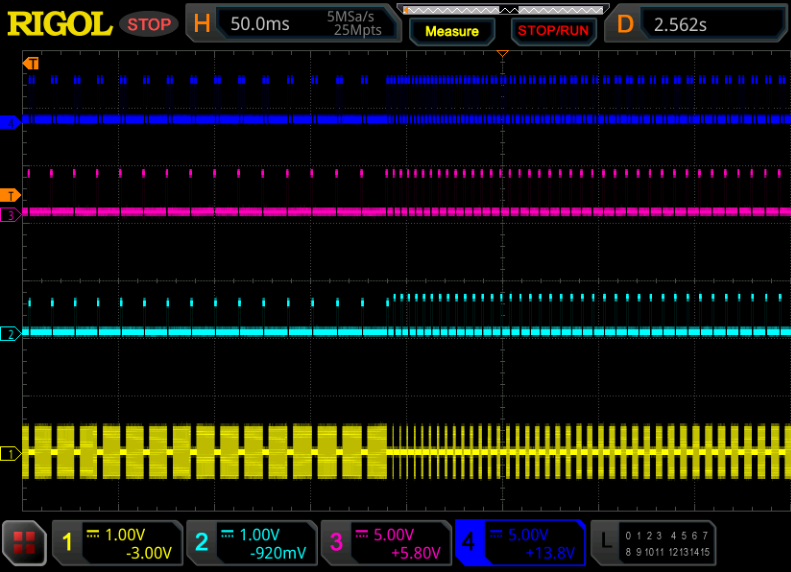 | 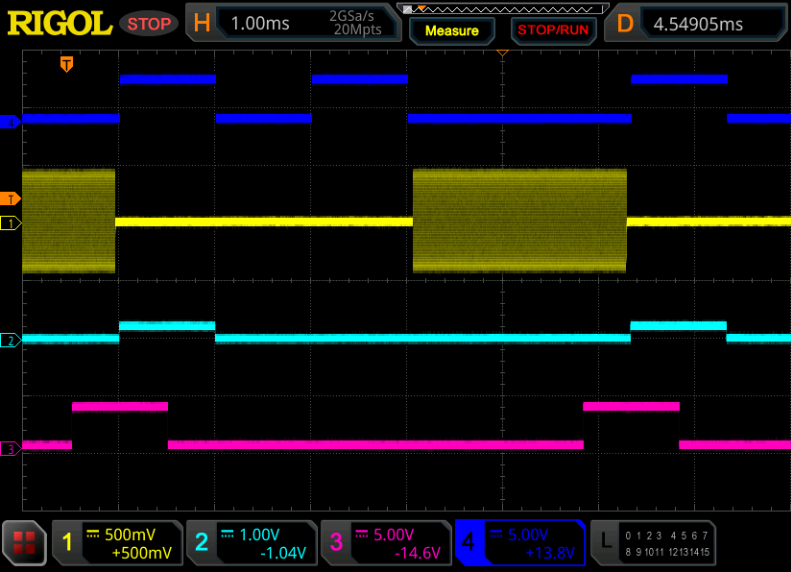 | 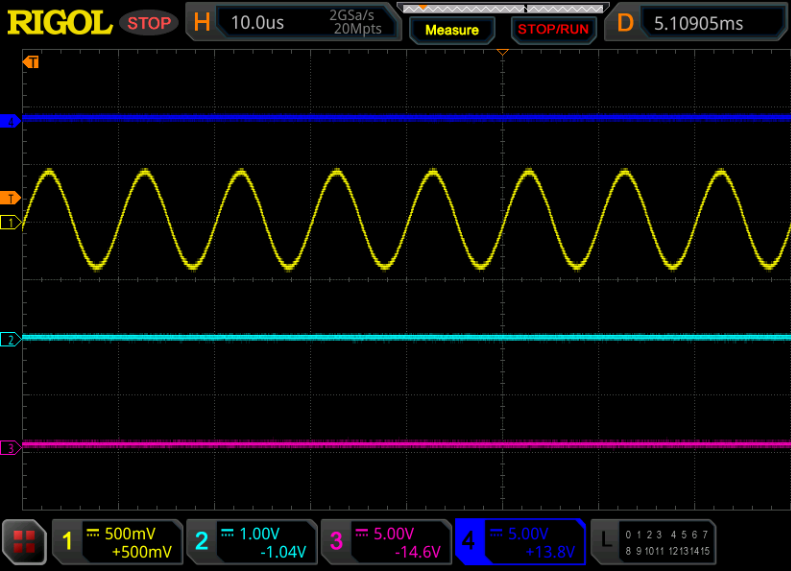

### Reset cards

In [20]:
ni_streamer.reset_all()